# Jack's Car Rental


## Example 4.2
Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited $\$10$ by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of $\$2$ per car moved. 
We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number is ${\lambda^n e^{-\lambda}\over n!}$ where $\lambda$ is the expected number. Suppose $\lambda$ is $3$ and $4$ for rental requests at the first and second locations and $3$ and $2$ for returns. To simplify the problem slightly, we assume that there can be no more than $20$ cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be $\gamma = 0.9$ and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time

%matplotlib inline
from mpl_toolkits import mplot3d

In [2]:
def hitmap(pi):
    ax = sns.heatmap(pi, linewidth=0)
    ax.invert_yaxis()
    plt.show()
    #print(pi)

## Modeling The Environment 

In [3]:
def Poisson(lmbda, n):
    return (lmbda ** n) * np.exp(-lmbda)/math.factorial(n)

In [4]:
def Prob(P, index, Max):
    if index == 0 and Max ==0:
        return 1
    if index < Max:
        return P[index]
    else:
        return 1 - sum(P[:Max])

In [5]:
def transition(states, P_req1, P_req2, P_ret1, P_ret2):
    
    transition_P = np.zeros((21,21,21,21))
    transition_R = np.zeros((21,21,21,21))
    
    for state in states:
        s_1, s_2 = state
        for req1 in range(s_1 + 1):
            p_1 = Prob(P_req1, req1, s_1)
            
            for req2 in range(s_2 +1):
                p_2 = Prob(P_req2, req2, s_2)
                    
                for rtrn1 in range(20 - (s_1 - req1) + 1):
                    q_1 = Prob(P_ret1, rtrn1, 20 - (s_1 - req1))
                    
                    for rtrn2 in range(20 - (s_2 - req2) + 1):
                        q_2 = Prob(P_ret2, rtrn2, 20 - (s_2 - req2))
                        
                        s1_new, s2_new = s_1 - req1 + rtrn1, s_2 - req2 + rtrn2
                        transition_P[s_1, s_2, s1_new, s2_new] += p_1*p_2*q_1*q_2
                        transition_R[s_1, s_2, s1_new, s2_new] += p_1*p_2*q_1*q_2 * 10 * (req1 + req2) 
                        
    return transition_P, transition_R

In [6]:
T_1 = time.time()


lambda_request_1 = 3
lambda_request_2 = 4
lambda_return_1 = 3
lambda_return_2 = 2

states = [(i,j) for i in range(21) for j in range(21)]

P_req1 = [Poisson(lambda_request_1, n) for n in range(20)]
P_req2 = [Poisson(lambda_request_2, n) for n in range(20)]
P_ret1 = [Poisson(lambda_return_1, n) for n in range(20)]
P_ret2 = [Poisson(lambda_return_2, n) for n in range(20)]

transition_P, transition_R = transition(states,
                                        P_req1,
                                        P_req2, 
                                        P_ret1,
                                        P_ret2)

print("Transition is DONE in %s seconds" %(time.time()-T_1))

Transition is DONE in 51.07560610771179 seconds


## 1. Policy Iteration Method

Here, we first sovle the problem using policy iteration methos.

In [7]:
class CarRental:
    def __init__(self, discout = .9, theta = 1e-2):
        
        self.gamma = discout
        self.theta = theta

        self.states = [(i,j) for i in range(21) for j in range(21)]
        
        self.V = np.zeros((21,21))
        self.pi = np.zeros((21,21)).astype(int)
        
        
        self.V_history = []
        
        self.Policy_Stable = False 
        
        T = time.time()
        self.run()
        print("DONE in %s seconds" %(time.time() - T))
        
    
    
    def run(self):
        
        hitmap(self.pi)
        
        Round = 0
        
        while not self.Policy_Stable:
            self.Policy_Stable = True            
            self.Policy_Evaluation()
            Round += 1
            print("Policy_Improvement starts for the %s-th time" %Round)
            old_pi = self.pi.copy()
            self.Policy_Improvement()
            hitmap(self.pi)
            print("Number of channges:", (old_pi != self.pi).sum())
            
        
        
    def Policy_Evaluation(self):
        
        Delta = 1
        counter = 0
        while Delta >= self.theta:
            counter += 1
            Delta = 0
            for s in self.states:
                
                s_1,s_2 = s
                old_v = self.V[s_1,s_2]
                
                self.V[s_1,s_2] = self.Q(s, self.pi[s_1,s_2])

                Delta = max(Delta, np.abs(old_v - self.V[s_1,s_2]))
                
                
                
    def Policy_Improvement(self):
        
        
        for s in self.states:
            s_1, s_2 = s
            Max = -np.inf
            for a in range(-min(s_2, 5, 20 - s_1), min(s_1, 20 - s_2, 5)+1):
                temp = self.Q(s, a)
                if temp > Max + 1e-3:
                    Max = temp
                    Best_Action = a
                    
                    
            if self.pi[s] != Best_Action:
                self.Policy_Stable = False                   
                self.pi[s] = Best_Action
            
                                   
   
    def Q(self, s, a):
    
        s_1, s_2 = s
        s_1 -= a
        s_2 += a
        
        Sum = -2 * np.abs(a)
        
        for state in self.states:
            x, y = state
            Sum += (transition_R[s_1, s_2, x, y] + 
                    transition_P[s_1, s_2, x, y] * 
                    self.gamma * self.V[x, y]
                   )  
        return Sum   

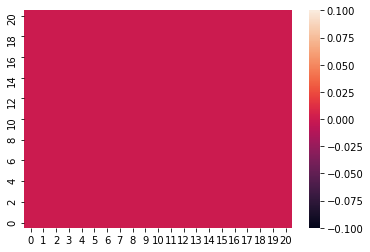

Policy_Improvement starts for the 1-th time


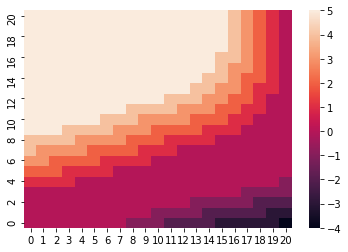

Number of channges: 318
Policy_Improvement starts for the 2-th time


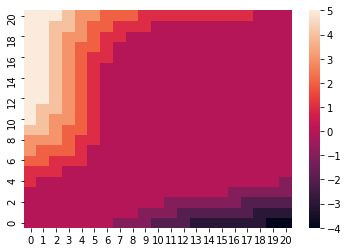

Number of channges: 272
Policy_Improvement starts for the 3-th time


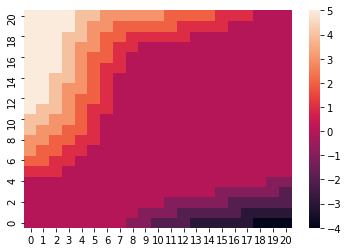

Number of channges: 79
Policy_Improvement starts for the 4-th time


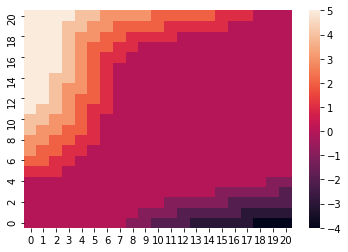

Number of channges: 8
Policy_Improvement starts for the 5-th time


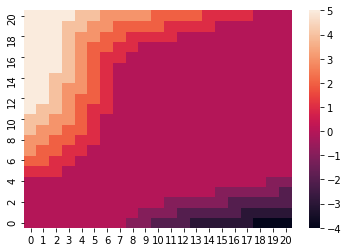

Number of channges: 2
Policy_Improvement starts for the 6-th time


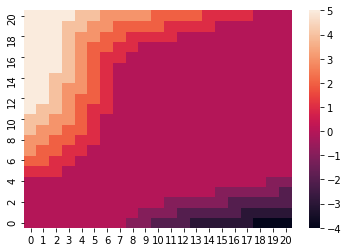

Number of channges: 0
DONE in 89.32539892196655 seconds


In [8]:
model = CarRental(discout = 0.9)

## Optimal policy and Value function

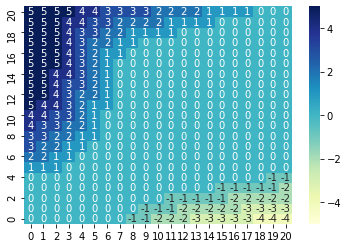

In [9]:
ax = sns.heatmap(model.pi, cmap="YlGnBu", annot=True, vmin=-5, vmax=5)
ax.invert_yaxis()
plt.show()

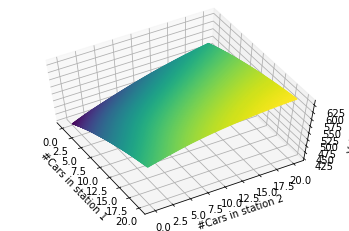

In [10]:
X = Y = np.arange(21).astype(int)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, model.V, 1000, cmap='viridis')
ax.set_xlabel('#Cars in station 1')
ax.set_ylabel('#Cars in station 2')
ax.set_zlabel('Value');
ax.view_init(60, -30)

## 2. Value Iteration Method

We here resolve the above problem using value-iteration method.

In [11]:
class CarRental_Value(CarRental):
    def __init__(self, discout = .9, theta = 1e-2):
        
        super().__init__(discout, theta)
        
    def run(self):
        Delta = 1
        while Delta > self.theta:
            Delta = 0
            for s in self.states:
                s_1, s_2 = s
                Max = -np.inf
                v_old = self.V[s]
                for a in range(-min(s_2, 5, 20 - s_1), min(s_1, 20 - s_2, 5)+1):
                    temp = self.Q(s, a)
                    if temp > Max + 1e-3:
                        Max = temp
                        Best_Action = a
                        
                Delta = max(Delta, np.abs(v_old - Max))
                
                self.V[s] = Max
                self.pi[s] = Best_Action                
        hitmap(self.pi)

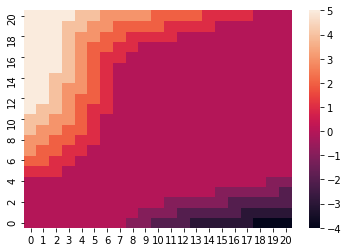

DONE in 167.21186876296997 seconds


In [12]:
model2 = CarRental_Value(discout = 0.9)

## Optimal policy and Value function

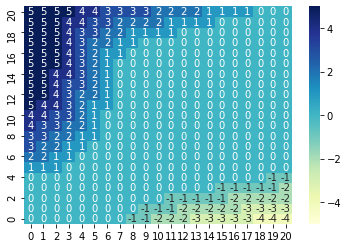

In [13]:
ax = sns.heatmap(model2.pi, cmap="YlGnBu", annot=True, vmin=-5, vmax=5)
ax.invert_yaxis()
plt.show()

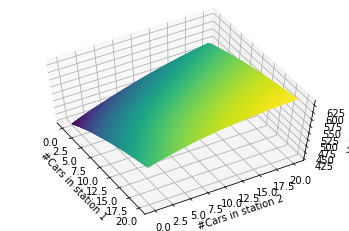

In [14]:
X = Y = np.arange(21).astype(int)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, model2.V, 1000, cmap='viridis')
ax.set_xlabel('#Cars in station 1')
ax.set_ylabel('#Cars in station 2')
ax.set_zlabel('Value');
ax.view_init(60, -30)

## Number of differences between policies obtained by Policy-Iteration and Value-Iteration methods

In [15]:
(model.pi != model2.pi).sum()

0

## Exercise 4.7

Write a program for policy iteration and re-solve Jack’s car rental problem with the following changes. One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs $\$2$, as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If more than $10$ cars are kept overnight at a location (after any moving of cars), then an additional cost of $\$4$ must be incurred to use a second parking lot (independent of how many cars are kept there). These sorts of nonlinearities and arbitrary dynamics often occur in real problems and cannot easily be handled by optimization methods other than dynamic programming. To check your program, first replicate the results given for the original problem.


## <font color='red'> Ambiguity: </font>
### <font color='blue'>  Based on the new changes, can Jack shuttle $6$ cars from the first location to the second one? We wrote the program assuming that Jack is still able to shuttle only $5$ cars from one station to the other.</font>


## 1. Policy Iteration Method

In [16]:
class CarRental2(CarRental):
    def __init__(self, discout = .9, theta = 1e-3):
        
        super().__init__(discout, theta)

        
    def Policy_Improvement(self):
        
        
        for s in self.states:
            s_1, s_2 = s
            Max = -np.inf
            for a in range(-min(s_2, 5, 20 - s_1), min(s_1, 20 - s_2, 5)+1): # second 5 ---> 6??
                temp = self.Q(s, a)
                if temp > Max + 1e-3:
                    Max = temp
                    Best_Action = a
                    
                    
            if self.pi[s] != Best_Action:
                self.Policy_Stable = False                   
                self.pi[s] = Best_Action        
        
        
    def Q(self, s, a):
    
        s_1, s_2 = s
        s_1 -= a
        s_2 += a
        
        RR = 0
        
        if s_1>10:
            RR += 4
        if s_2>10:
            RR += 4
        
        if a>0:
            Sum = -2 * (a -1) - RR
        else:
            Sum = 2 * a - RR
            
        
        for state in self.states:
            x, y = state
            Sum += (transition_R[s_1, s_2, x, y] + 
                    transition_P[s_1, s_2, x, y] * 
                    self.gamma * self.V[x, y]
                   )  
        return Sum 

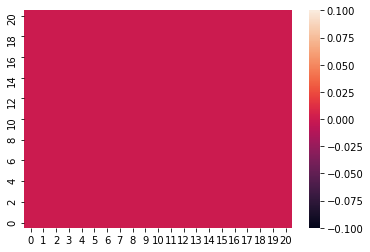

Policy_Improvement starts for the 1-th time


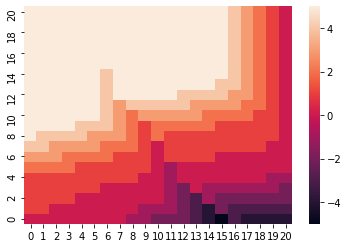

Number of channges: 371
Policy_Improvement starts for the 2-th time


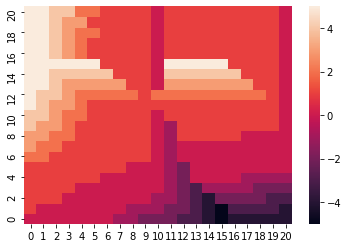

Number of channges: 265
Policy_Improvement starts for the 3-th time


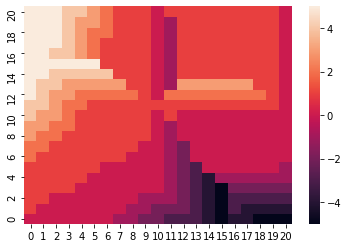

Number of channges: 102
Policy_Improvement starts for the 4-th time


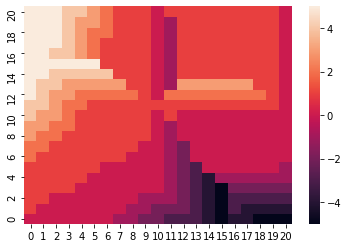

Number of channges: 0
DONE in 83.76932716369629 seconds


In [17]:
model3 = CarRental2(discout = 0.9)

## Optimal policy and Value function

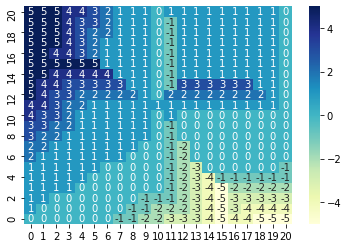

In [18]:
ax = sns.heatmap(model3.pi, cmap="YlGnBu", annot=True, vmin=-5, vmax=5)
ax.invert_yaxis()
plt.show()

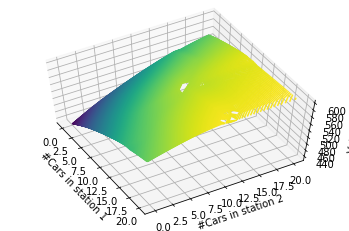

In [19]:
X = Y = np.arange(21).astype(int)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, model3.V, 1000, cmap='viridis')
ax.set_xlabel('#Cars in station 1')
ax.set_ylabel('#Cars in station 2')
ax.set_zlabel('Value');
ax.view_init(60, -30)

## 2. Value Iteration Method

We here resolve Exercise 4.7 using value-iteration method.

In [20]:
class CarRental2_Value(CarRental2):
    def __init__(self, discout = .9, theta = 1e-3):
        
        super().__init__(discout, theta)
        
    def run(self):
        Delta = 1
        while Delta > self.theta:
            Delta = 0
            for s in self.states:
                s_1, s_2 = s
                Max = -np.inf
                v_old = self.V[s]
                for a in range(-min(s_2, 5, 20 - s_1), min(s_1, 20 - s_2, 5)+1): # second 5 ---> 6??
                    temp = self.Q(s, a)
                    if temp > Max + 1e-3:
                        Max = temp
                        Best_Action = a
                        
                Delta = max(Delta, np.abs(v_old - Max))
                
                self.V[s] = Max
                self.pi[s] = Best_Action                
        hitmap(self.pi)

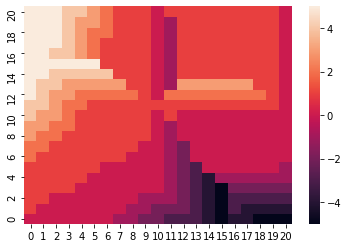

DONE in 204.83488202095032 seconds


In [21]:
model4 = CarRental2_Value(discout = 0.9)

## Number of differences between policies obtained by Policy-Iteration and Value-Iteration methods

In [22]:
(model3.pi != model4.pi).sum()

0

## Optimal policy and Value function

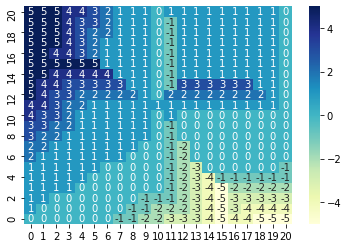

In [23]:
ax = sns.heatmap(model4.pi, cmap="YlGnBu", annot=True, vmin=-5, vmax=5)
ax.invert_yaxis()
plt.show()

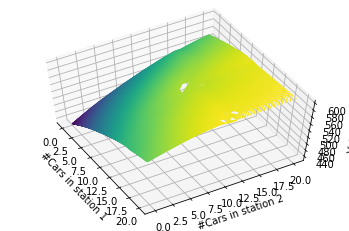

In [24]:
X = Y = np.arange(21).astype(int)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, model4.V, 1000, cmap='viridis')
ax.set_xlabel('#Cars in station 1')
ax.set_ylabel('#Cars in station 2')
ax.set_zlabel('Value');
ax.view_init(60, -30)

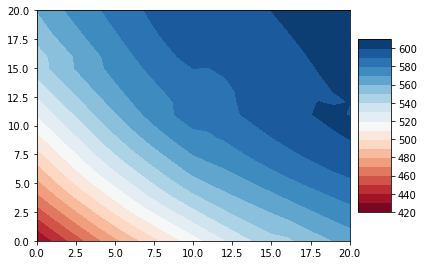

In [25]:
W = plt.contourf([_ for _ in range(21)], [_ for _ in range(21)], model4.V, 20, cmap='RdBu');
plt.subplots_adjust(bottom=0.1, right=0.85, top=0.9)
cax = plt.axes([0.87, 0.2, 0.075, 0.6])
plt.colorbar(cax=cax)
plt.show()